In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from sklearn.model_selection import KFold

In [2]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

#np.random.seed(4); #same set of numbers will appear every time
#np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size 

# spatial slicing dimensions
os = 8 # output slice size
halo = 2; # edge cells
ts = os + halo * 2 # total input slice size including halos 12
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 511; # number of slices in one profile 



In [4]:
#slicing the 4000 profiles 

image=np.zeros((l2r*num,ts,3)) #511*4000=2044000
label=np.zeros((l2r*num,os)) 

#cut each profile into 511 slices. 
#label: tau channel of the center of each slice(reduced domain), they ignore the edge pixel.
for i in range(num):
    for n in range(l2r):
        img= data[i,n*os:n*os+ts, 0:nchan] #input: 12 pixels for one slice, 3 channels 
        lb = data[i,n*os+halo:n*os+halo+os, nchan] #8 pixels for label,the tau channel is the label
        image[i*l2r+n]=img
        label[i*l2r+n]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #511*4000=2044000

whole dataset features size:  (2044000, 12, 3) whole dataset label size:  (2044000, 8)


In [5]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [13]:
# CNN over domain -------------------------------------------


def evaluate_model(train_image, test_image, train_label, test_label):
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 1024
    eps = 500
    
    model_m = models.Sequential()

    model_m.add(layers.Conv1D(nchan*100, kernel_size=ks, activation='relu', input_shape=(ts, nchan))) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.Conv1D(nchan*80, kernel_size=3, activation='relu')) #kernel size 4, 80 filters for each 3 channel
    model_m.add(layers.Dropout(0.2))
    model_m.add(layers.Conv1D(nchan*80, kernel_size=3, activation='relu')) #kernel size 4, 80 filters for each 3 channel
    model_m.add(layers.Dropout(0.2))
    model_m.add(layers.Conv1D(nchan*80, kernel_size=3, activation='relu')) #kernel size 4, 80 filters for each 3 channel
    model_m.add(layers.Dropout(0.1))
    model_m.add(layers.Conv1D(8, kernel_size=1)) 
    model_m.add(layers.Dropout(0.1))
    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(os, activation="linear"))#output slice size : 8

    model_m.summary()


    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------

    print('test result')
    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    rmse=results[2]
    
    return model_m,rmse,mse,history,predictions

In [7]:
#5-fold cross validation
n_folds=5

kf = KFold(n_splits=n_folds)
kf.get_n_splits(image)
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),12,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),8))
X_test=np.zeros((n_folds,ratio,12,3))
y_test=np.zeros((n_folds,ratio,8))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 408800  408801  408802 ... 2043997 2043998 2043999] TEST: [     0      1      2 ... 408797 408798 408799]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [408800 408801 408802 ... 817597 817598 817599]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [ 817600  817601  817602 ... 1226397 1226398 1226399]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [1226400 1226401 1226402 ... 1635197 1635198 1635199]
TRAIN: [      0       1       2 ... 1635197 1635198 1635199] TEST: [1635200 1635201 1635202 ... 2043997 2043998 2043999]


In [14]:
cv_scores=list()
cv_scores2=list()
model_history=list()

for n in range(n_folds):
    if n>0:
        # split data
        train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
        model_m,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
        print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
        print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

        cv_scores.append(mse)
        cv_scores2.append(rmse)

    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 7, 300)            5700      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5, 240)            216240    
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 240)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 3, 240)            173040    
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 240)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 240)            173040    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 240)           

Epoch 61/500
1398/1398 [==============================] - 15s 11ms/step - loss: 13.1840 - mean_squared_error: 13.1840 - root_mean_squared_error: 3.6308 - val_loss: 15.0285 - val_mean_squared_error: 15.0285 - val_root_mean_squared_error: 3.8767
Epoch 62/500
1398/1398 [==============================] - 15s 11ms/step - loss: 13.0585 - mean_squared_error: 13.0585 - root_mean_squared_error: 3.6135 - val_loss: 12.9093 - val_mean_squared_error: 12.9093 - val_root_mean_squared_error: 3.5930
Epoch 63/500
1398/1398 [==============================] - 15s 11ms/step - loss: 13.1416 - mean_squared_error: 13.1416 - root_mean_squared_error: 3.6244 - val_loss: 12.9308 - val_mean_squared_error: 12.9308 - val_root_mean_squared_error: 3.5959
Epoch 64/500
1398/1398 [==============================] - 15s 11ms/step - loss: 13.0794 - mean_squared_error: 13.0794 - root_mean_squared_error: 3.6164 - val_loss: 13.1359 - val_mean_squared_error: 13.1359 - val_root_mean_squared_error: 3.6243
Epoch 65/500
1398/1398 [

1398/1398 [==============================] - 15s 11ms/step - loss: 11.7802 - mean_squared_error: 11.7802 - root_mean_squared_error: 3.4320 - val_loss: 11.4074 - val_mean_squared_error: 11.4074 - val_root_mean_squared_error: 3.3775
Epoch 128/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.7962 - mean_squared_error: 11.7962 - root_mean_squared_error: 3.4344 - val_loss: 11.6763 - val_mean_squared_error: 11.6763 - val_root_mean_squared_error: 3.4171
Epoch 129/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.8218 - mean_squared_error: 11.8218 - root_mean_squared_error: 3.4382 - val_loss: 11.6037 - val_mean_squared_error: 11.6037 - val_root_mean_squared_error: 3.4064
Epoch 130/500
1398/1398 [==============================] - 16s 11ms/step - loss: 11.7051 - mean_squared_error: 11.7051 - root_mean_squared_error: 3.4210 - val_loss: 11.2772 - val_mean_squared_error: 11.2772 - val_root_mean_squared_error: 3.3581
Epoch 131/500
1398/1398 [=========

1398/1398 [==============================] - 15s 11ms/step - loss: 10.6517 - mean_squared_error: 10.6517 - root_mean_squared_error: 3.2636 - val_loss: 10.4620 - val_mean_squared_error: 10.4620 - val_root_mean_squared_error: 3.2345
Epoch 194/500
1398/1398 [==============================] - 15s 11ms/step - loss: 10.3690 - mean_squared_error: 10.3690 - root_mean_squared_error: 3.2200 - val_loss: 10.2309 - val_mean_squared_error: 10.2309 - val_root_mean_squared_error: 3.1986
Epoch 195/500
1398/1398 [==============================] - 15s 11ms/step - loss: 10.5206 - mean_squared_error: 10.5206 - root_mean_squared_error: 3.2434 - val_loss: 10.8666 - val_mean_squared_error: 10.8666 - val_root_mean_squared_error: 3.2965
Epoch 196/500
1398/1398 [==============================] - 15s 11ms/step - loss: 10.5591 - mean_squared_error: 10.5591 - root_mean_squared_error: 3.2494 - val_loss: 10.7636 - val_mean_squared_error: 10.7636 - val_root_mean_squared_error: 3.2808
Epoch 197/500
1398/1398 [=========

Epoch 260/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.7523 - mean_squared_error: 9.7523 - root_mean_squared_error: 3.1227 - val_loss: 9.3548 - val_mean_squared_error: 9.3548 - val_root_mean_squared_error: 3.0586
Epoch 261/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.7877 - mean_squared_error: 9.7877 - root_mean_squared_error: 3.1283 - val_loss: 10.8654 - val_mean_squared_error: 10.8654 - val_root_mean_squared_error: 3.2963
Epoch 262/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.9022 - mean_squared_error: 9.9022 - root_mean_squared_error: 3.1467 - val_loss: 9.8202 - val_mean_squared_error: 9.8202 - val_root_mean_squared_error: 3.1337
Epoch 263/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.7148 - mean_squared_error: 9.7148 - root_mean_squared_error: 3.1168 - val_loss: 9.2092 - val_mean_squared_error: 9.2092 - val_root_mean_squared_error: 3.0347
Epoch 264/500
1398/1398 [=========

Epoch 294/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.5179 - mean_squared_error: 9.5179 - root_mean_squared_error: 3.0850 - val_loss: 9.3156 - val_mean_squared_error: 9.3156 - val_root_mean_squared_error: 3.0521
Restoring model weights from the end of the best epoch.
Epoch 00294: early stopping
test result
12775/12775 [==============================] - 43s 3ms/step - loss: 9.2245 - mean_squared_error: 9.2245 - root_mean_squared_error: 3.0372
MSE on test set in fold2 : 9.224517822265625
RMSE on test set in fold2 : 3.037189245223999
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 7, 300)            5700      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5, 240)            216240    
_________________________________________________________________
dropout_12 (Drop

Epoch 25/500
1398/1398 [==============================] - 15s 11ms/step - loss: 15.1889 - mean_squared_error: 15.1889 - root_mean_squared_error: 3.8970 - val_loss: 14.1970 - val_mean_squared_error: 14.1970 - val_root_mean_squared_error: 3.7679
Epoch 26/500
1398/1398 [==============================] - 15s 11ms/step - loss: 15.0355 - mean_squared_error: 15.0355 - root_mean_squared_error: 3.8775 - val_loss: 13.5023 - val_mean_squared_error: 13.5023 - val_root_mean_squared_error: 3.6745
Epoch 27/500
1398/1398 [==============================] - 15s 11ms/step - loss: 15.2268 - mean_squared_error: 15.2268 - root_mean_squared_error: 3.9020 - val_loss: 13.1446 - val_mean_squared_error: 13.1446 - val_root_mean_squared_error: 3.6256
Epoch 28/500
1398/1398 [==============================] - 15s 11ms/step - loss: 14.7363 - mean_squared_error: 14.7363 - root_mean_squared_error: 3.8387 - val_loss: 13.3060 - val_mean_squared_error: 13.3060 - val_root_mean_squared_error: 3.6477
Epoch 29/500
1398/1398 [

Epoch 92/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.7882 - mean_squared_error: 11.7882 - root_mean_squared_error: 3.4333 - val_loss: 11.5950 - val_mean_squared_error: 11.5950 - val_root_mean_squared_error: 3.4051
Epoch 93/500
1398/1398 [==============================] - 15s 11ms/step - loss: 12.0039 - mean_squared_error: 12.0039 - root_mean_squared_error: 3.4642 - val_loss: 11.1894 - val_mean_squared_error: 11.1894 - val_root_mean_squared_error: 3.3451
Epoch 94/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.7856 - mean_squared_error: 11.7856 - root_mean_squared_error: 3.4329 - val_loss: 11.7637 - val_mean_squared_error: 11.7637 - val_root_mean_squared_error: 3.4298
Epoch 95/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.7095 - mean_squared_error: 11.7095 - root_mean_squared_error: 3.4219 - val_loss: 10.8794 - val_mean_squared_error: 10.8794 - val_root_mean_squared_error: 3.2984
Epoch 96/500
1398/1398 [

Epoch 159/500
1398/1398 [==============================] - 15s 11ms/step - loss: 10.3157 - mean_squared_error: 10.3157 - root_mean_squared_error: 3.2118 - val_loss: 9.7507 - val_mean_squared_error: 9.7507 - val_root_mean_squared_error: 3.1226
Epoch 160/500
1398/1398 [==============================] - 15s 10ms/step - loss: 10.3636 - mean_squared_error: 10.3636 - root_mean_squared_error: 3.2191 - val_loss: 9.3987 - val_mean_squared_error: 9.3987 - val_root_mean_squared_error: 3.0657
Epoch 161/500
1398/1398 [==============================] - 14s 10ms/step - loss: 10.1834 - mean_squared_error: 10.1834 - root_mean_squared_error: 3.1911 - val_loss: 9.3723 - val_mean_squared_error: 9.3723 - val_root_mean_squared_error: 3.0614
Epoch 162/500
1398/1398 [==============================] - 14s 10ms/step - loss: 10.2825 - mean_squared_error: 10.2825 - root_mean_squared_error: 3.2065 - val_loss: 9.5422 - val_mean_squared_error: 9.5422 - val_root_mean_squared_error: 3.0890
Epoch 163/500
1398/1398 [===

Epoch 193/500
1398/1398 [==============================] - 15s 11ms/step - loss: 10.0044 - mean_squared_error: 10.0044 - root_mean_squared_error: 3.1628 - val_loss: 9.7140 - val_mean_squared_error: 9.7140 - val_root_mean_squared_error: 3.1167
Epoch 194/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.9562 - mean_squared_error: 9.9562 - root_mean_squared_error: 3.1553 - val_loss: 9.4773 - val_mean_squared_error: 9.4773 - val_root_mean_squared_error: 3.0785
Epoch 195/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.9157 - mean_squared_error: 9.9157 - root_mean_squared_error: 3.1489 - val_loss: 9.7827 - val_mean_squared_error: 9.7827 - val_root_mean_squared_error: 3.1277
Epoch 196/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.7816 - mean_squared_error: 9.7816 - root_mean_squared_error: 3.1275 - val_loss: 8.8973 - val_mean_squared_error: 8.8973 - val_root_mean_squared_error: 2.9828
Epoch 197/500
1398/1398 [=========

Epoch 227/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.6983 - mean_squared_error: 9.6983 - root_mean_squared_error: 3.1141 - val_loss: 8.5566 - val_mean_squared_error: 8.5566 - val_root_mean_squared_error: 2.9252
Epoch 228/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.6615 - mean_squared_error: 9.6615 - root_mean_squared_error: 3.1081 - val_loss: 8.7100 - val_mean_squared_error: 8.7100 - val_root_mean_squared_error: 2.9513
Epoch 229/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.6135 - mean_squared_error: 9.6135 - root_mean_squared_error: 3.1003 - val_loss: 9.1496 - val_mean_squared_error: 9.1496 - val_root_mean_squared_error: 3.0248
Epoch 230/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.6406 - mean_squared_error: 9.6406 - root_mean_squared_error: 3.1048 - val_loss: 8.5080 - val_mean_squared_error: 8.5080 - val_root_mean_squared_error: 2.9169
Epoch 231/500
1398/1398 [===========

Epoch 1/500
1398/1398 [==============================] - 16s 11ms/step - loss: 30.1394 - mean_squared_error: 30.1394 - root_mean_squared_error: 5.4582 - val_loss: 21.5194 - val_mean_squared_error: 21.5194 - val_root_mean_squared_error: 4.6389
Epoch 2/500
1398/1398 [==============================] - 15s 11ms/step - loss: 23.4113 - mean_squared_error: 23.4113 - root_mean_squared_error: 4.8382 - val_loss: 21.0494 - val_mean_squared_error: 21.0494 - val_root_mean_squared_error: 4.5880
Epoch 3/500
1398/1398 [==============================] - 15s 11ms/step - loss: 22.3960 - mean_squared_error: 22.3960 - root_mean_squared_error: 4.7322 - val_loss: 22.2338 - val_mean_squared_error: 22.2338 - val_root_mean_squared_error: 4.7153
Epoch 4/500
1398/1398 [==============================] - 15s 11ms/step - loss: 21.9963 - mean_squared_error: 21.9963 - root_mean_squared_error: 4.6899 - val_loss: 20.9953 - val_mean_squared_error: 20.9953 - val_root_mean_squared_error: 4.5821
Epoch 5/500
1398/1398 [=====

Epoch 35/500
1398/1398 [==============================] - 15s 11ms/step - loss: 15.0939 - mean_squared_error: 15.0939 - root_mean_squared_error: 3.8850 - val_loss: 16.9482 - val_mean_squared_error: 16.9482 - val_root_mean_squared_error: 4.1168
Epoch 36/500
1398/1398 [==============================] - 15s 11ms/step - loss: 15.1847 - mean_squared_error: 15.1847 - root_mean_squared_error: 3.8963 - val_loss: 15.1001 - val_mean_squared_error: 15.1001 - val_root_mean_squared_error: 3.8859
Epoch 37/500
1398/1398 [==============================] - 15s 11ms/step - loss: 14.9611 - mean_squared_error: 14.9611 - root_mean_squared_error: 3.8679 - val_loss: 15.8368 - val_mean_squared_error: 15.8368 - val_root_mean_squared_error: 3.9795
Epoch 38/500
1398/1398 [==============================] - 15s 11ms/step - loss: 14.7924 - mean_squared_error: 14.7924 - root_mean_squared_error: 3.8461 - val_loss: 15.6234 - val_mean_squared_error: 15.6234 - val_root_mean_squared_error: 3.9526
Epoch 39/500
1398/1398 [

Epoch 102/500
1398/1398 [==============================] - 15s 11ms/step - loss: 12.9843 - mean_squared_error: 12.9843 - root_mean_squared_error: 3.6033 - val_loss: 14.9840 - val_mean_squared_error: 14.9840 - val_root_mean_squared_error: 3.8709
Epoch 103/500
1398/1398 [==============================] - 15s 11ms/step - loss: 12.8263 - mean_squared_error: 12.8263 - root_mean_squared_error: 3.5813 - val_loss: 14.1520 - val_mean_squared_error: 14.1520 - val_root_mean_squared_error: 3.7619
Epoch 104/500
1398/1398 [==============================] - 15s 11ms/step - loss: 12.8715 - mean_squared_error: 12.8715 - root_mean_squared_error: 3.5876 - val_loss: 14.6921 - val_mean_squared_error: 14.6921 - val_root_mean_squared_error: 3.8330
Epoch 105/500
1398/1398 [==============================] - 15s 11ms/step - loss: 12.8058 - mean_squared_error: 12.8058 - root_mean_squared_error: 3.5782 - val_loss: 14.0455 - val_mean_squared_error: 14.0455 - val_root_mean_squared_error: 3.7477
Epoch 106/500
1398/1

Epoch 13/500
1398/1398 [==============================] - 15s 11ms/step - loss: 18.7921 - mean_squared_error: 18.7921 - root_mean_squared_error: 4.3347 - val_loss: 16.7640 - val_mean_squared_error: 16.7640 - val_root_mean_squared_error: 4.0944
Epoch 14/500
1398/1398 [==============================] - 15s 11ms/step - loss: 17.7697 - mean_squared_error: 17.7697 - root_mean_squared_error: 4.2152 - val_loss: 16.3070 - val_mean_squared_error: 16.3070 - val_root_mean_squared_error: 4.0382
Epoch 15/500
1398/1398 [==============================] - 15s 11ms/step - loss: 18.1768 - mean_squared_error: 18.1768 - root_mean_squared_error: 4.2628 - val_loss: 16.0023 - val_mean_squared_error: 16.0023 - val_root_mean_squared_error: 4.0003
Epoch 16/500
1398/1398 [==============================] - 15s 11ms/step - loss: 17.4156 - mean_squared_error: 17.4156 - root_mean_squared_error: 4.1731 - val_loss: 17.0293 - val_mean_squared_error: 17.0293 - val_root_mean_squared_error: 4.1267
Epoch 17/500
1398/1398 [

Epoch 80/500
1398/1398 [==============================] - 15s 11ms/step - loss: 13.1972 - mean_squared_error: 13.1972 - root_mean_squared_error: 3.6327 - val_loss: 13.3572 - val_mean_squared_error: 13.3572 - val_root_mean_squared_error: 3.6548
Epoch 81/500
1398/1398 [==============================] - 15s 11ms/step - loss: 13.2432 - mean_squared_error: 13.2432 - root_mean_squared_error: 3.6391 - val_loss: 11.4880 - val_mean_squared_error: 11.4880 - val_root_mean_squared_error: 3.3894
Epoch 82/500
1398/1398 [==============================] - 15s 11ms/step - loss: 12.8151 - mean_squared_error: 12.8151 - root_mean_squared_error: 3.5798 - val_loss: 11.9271 - val_mean_squared_error: 11.9271 - val_root_mean_squared_error: 3.4536
Epoch 83/500
1398/1398 [==============================] - 15s 11ms/step - loss: 12.9272 - mean_squared_error: 12.9272 - root_mean_squared_error: 3.5953 - val_loss: 11.2980 - val_mean_squared_error: 11.2980 - val_root_mean_squared_error: 3.3612
Epoch 84/500
1398/1398 [

1398/1398 [==============================] - 15s 11ms/step - loss: 12.0012 - mean_squared_error: 12.0012 - root_mean_squared_error: 3.4642 - val_loss: 9.7287 - val_mean_squared_error: 9.7287 - val_root_mean_squared_error: 3.1191
Epoch 147/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.7811 - mean_squared_error: 11.7811 - root_mean_squared_error: 3.4322 - val_loss: 10.1796 - val_mean_squared_error: 10.1796 - val_root_mean_squared_error: 3.1905
Epoch 148/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.9152 - mean_squared_error: 11.9152 - root_mean_squared_error: 3.4517 - val_loss: 10.1263 - val_mean_squared_error: 10.1263 - val_root_mean_squared_error: 3.1822
Epoch 149/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.9405 - mean_squared_error: 11.9405 - root_mean_squared_error: 3.4552 - val_loss: 10.8646 - val_mean_squared_error: 10.8646 - val_root_mean_squared_error: 3.2961
Epoch 150/500
1398/1398 [===========

Epoch 180/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.1477 - mean_squared_error: 11.1477 - root_mean_squared_error: 3.3388 - val_loss: 9.5630 - val_mean_squared_error: 9.5630 - val_root_mean_squared_error: 3.0924
Epoch 181/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.0695 - mean_squared_error: 11.0695 - root_mean_squared_error: 3.3269 - val_loss: 9.7120 - val_mean_squared_error: 9.7120 - val_root_mean_squared_error: 3.1164
Epoch 182/500
1398/1398 [==============================] - 15s 11ms/step - loss: 11.0605 - mean_squared_error: 11.0605 - root_mean_squared_error: 3.3256 - val_loss: 9.0475 - val_mean_squared_error: 9.0475 - val_root_mean_squared_error: 3.0079
Epoch 183/500
1398/1398 [==============================] - 15s 11ms/step - loss: 10.9302 - mean_squared_error: 10.9302 - root_mean_squared_error: 3.3061 - val_loss: 9.0209 - val_mean_squared_error: 9.0209 - val_root_mean_squared_error: 3.0035
Epoch 184/500
1398/1398 [===

Epoch 247/500
1398/1398 [==============================] - 15s 11ms/step - loss: 10.0276 - mean_squared_error: 10.0276 - root_mean_squared_error: 3.1666 - val_loss: 8.4117 - val_mean_squared_error: 8.4117 - val_root_mean_squared_error: 2.9003
Epoch 248/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.9267 - mean_squared_error: 9.9267 - root_mean_squared_error: 3.1505 - val_loss: 8.4740 - val_mean_squared_error: 8.4740 - val_root_mean_squared_error: 2.9110
Epoch 249/500
1398/1398 [==============================] - 15s 11ms/step - loss: 10.1229 - mean_squared_error: 10.1229 - root_mean_squared_error: 3.1815 - val_loss: 8.3975 - val_mean_squared_error: 8.3975 - val_root_mean_squared_error: 2.8978
Epoch 250/500
1398/1398 [==============================] - 15s 11ms/step - loss: 9.9319 - mean_squared_error: 9.9319 - root_mean_squared_error: 3.1514 - val_loss: 7.9722 - val_mean_squared_error: 7.9722 - val_root_mean_squared_error: 2.8235
Epoch 251/500
1398/1398 [=======

In [28]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 10.1402 with standard deviation (1.8031)
Estimated RMSE 3.1721 with standard deviation (0.2796)


In [20]:
cv_scores

[9.224517822265625,
 8.435938835144043,
 12.686403274536133,
 8.441144943237305,
 11.9132]

In [22]:
cv_scores2

[3.037189245223999,
 2.9044687747955322,
 3.5617973804473877,
 2.905364751815796,
 3.4516]

The optimal number of epochs is 267 in the last fold.


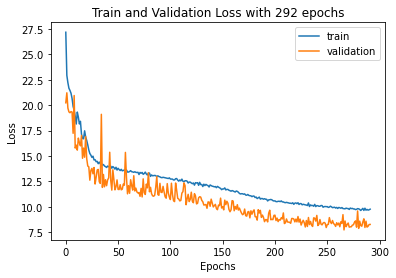

In [24]:
patience=25
# plot training and validation history in the last fold
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience)+' in the last fold.')